In [820]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
%matplotlib inline
import fitsio
from glob import glob
import numpy as np
from tqdm import tqdm
from photutils import DAOStarFinder,IRAFStarFinder
from astropy.stats import sigma_clipped_stats
from matplotlib import animation
import pickle
import warnings
warnings.filterwarnings("ignore")

In [821]:
cmap = plt.get_cmap('gray')
cmap.set_bad('black',1.)
fnames=glob('../data/*.fits')
cad=np.asarray([float((f.split('-cad')[-1])[:-5]) for f in fnames])

In [304]:
tpf0 = fitsio.FITS(fnames[0])[1].read()

In [728]:
families=pickle.load(open('../source/families.p','rb'))

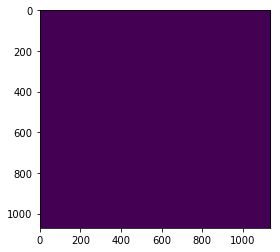

In [800]:
blank=np.copy(tpf0)*0.
blank[np.isfinite(blank)==False]=0
plt.imshow(blank)

In [804]:
import sys
sys.path.append('../source/')
import sourcetrack as st
%load_ext autoreload
%autoreload(2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [809]:
st=pickle.load(open('../source/stabilise.p','rb'))

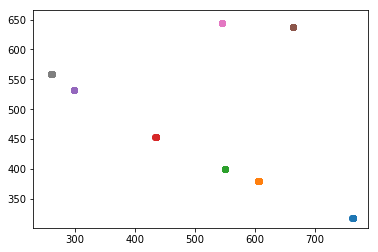

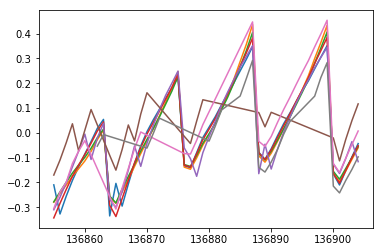

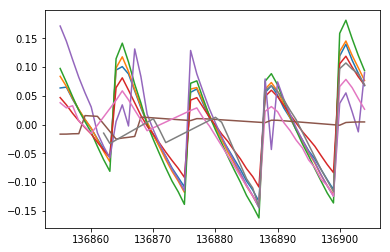

In [815]:
plt.figure()
for s in st:
    plt.scatter(s['x'],s['y'])
plt.figure()
for s in st:
    plt.plot(s['c'],s['x']-np.mean(s['x']))
plt.figure()
for s in st:
    plt.plot(s['c'],s['y']-np.mean(s['y']))
    


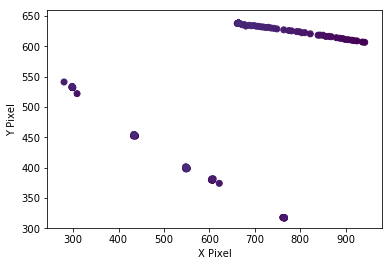

In [708]:
for f in families:
    if len(f['x'])<10:
        continue
    plt.scatter(f['x'],f['y'],c=f['c'],vmin=cad[1],vmax=cad[-1])
    plt.xlabel('X Pixel')
    plt.ylabel('Y Pixel')

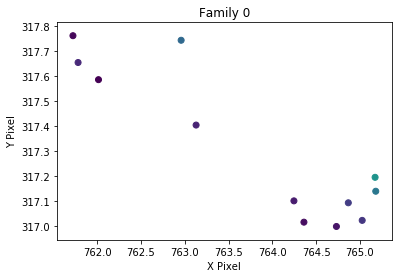

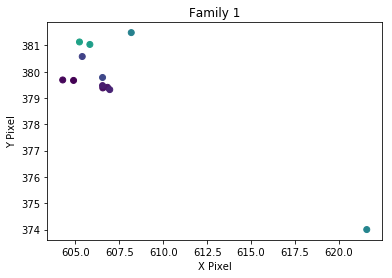

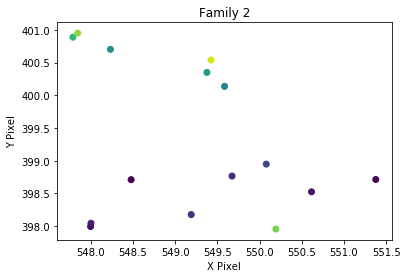

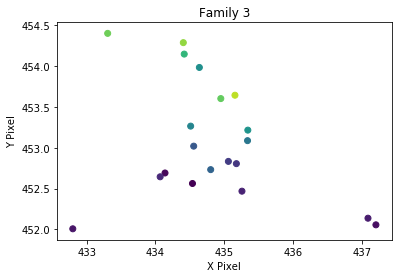

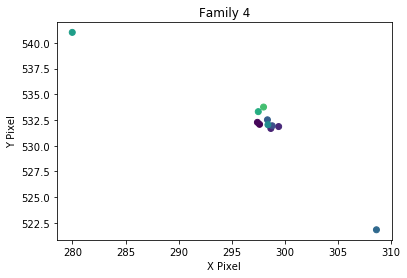

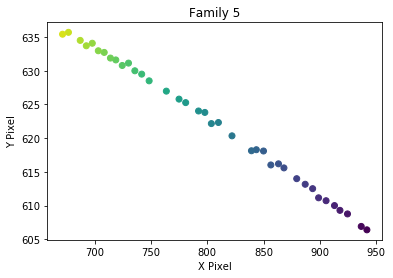

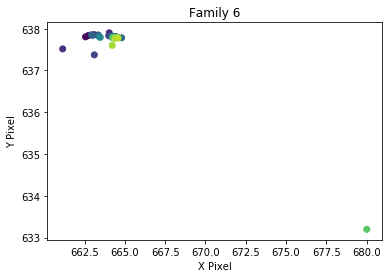

In [709]:
for i,f in enumerate(families):
    if len(f['x'])<10:
        continue
    plt.figure()
    plt.scatter(f['x'],f['y'],c=f['c'],vmin=cad[1],vmax=cad[500])
    plt.title('Family {}'.format(i))
    plt.xlabel('X Pixel')
    plt.ylabel('Y Pixel')


In [167]:
from photutils import DAOStarFinder
from astropy.stats import sigma_clipped_stats

lastx,lasty=920,610
xs,ys=np.zeros(len(fnames)),np.zeros(len(fnames))
ts=np.linspace(0,len(fnames),len(fnames)/10,dtype=int)-1
ts[0]=0
for i,c,f in tqdm(zip(ts,cad[ts],np.asarray(fnames)[ts])):
    tpf = fitsio.FITS(f)
    data=tpf[1].read()-tpf0
    tpf.close()
    mean, median, std = sigma_clipped_stats(data, sigma=3.0, iters=5)    
    data[np.isfinite(data)==False]=0
    daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)    
    sources = daofind(data - median)    
   
    pos=np.where(sources['peak']>150)[0]
    if len(pos)==0:
        continue
    x,y=np.asarray(sources['xcentroid'][pos]),np.asarray(sources['ycentroid'][pos])
    dist=(((lastx-x)**2+(lasty-y)**2)**0.5)
    pos=np.where(dist<=30)[0]
    if len(pos)==0:
        continue
    src=pos[np.argmin(dist[pos])]

    xs[i],ys[i]=x[src],y[src]
    
    if len(np.where(xs!=0)[0])<5:
        lastx,lasty=x[src],y[src]
    else:
        lastx=np.polyval(np.polyfit(cad[np.where(xs!=0)],xs[np.where(xs!=0)],2),cad[i+1])
        lasty=np.polyval(np.polyfit(cad[np.where(ys!=0)],ys[np.where(ys!=0)],2),cad[i+1])
    

/Users/ch/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  

0it [00:00, ?it/s]WARNING: No sources were found. [photutils.detection.findstars]

1it [00:00,  2.02it/s]
/Users/ch/anaconda/lib/python3.6/site-packages/photutils/detection/findstars.py:637: RuntimeWarning: divide by zero encountered in double_scalars
  flux = (convpeak / threshold) - (sky * obj.size)
386it [05:08,  1.34it/s]


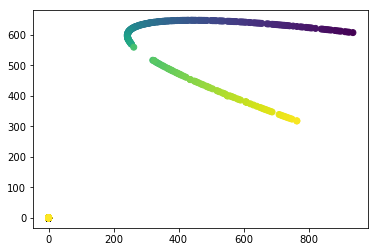

In [582]:
plt.scatter(xs,ys,c=np.arange(len(xs)))

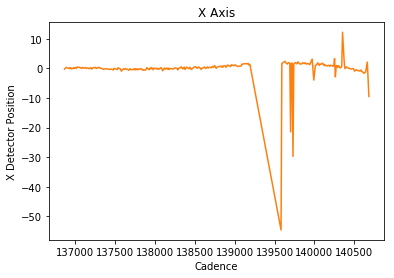

In [284]:
xlim=np.polyval(np.polyfit(cad[np.where(xs!=0)],xs[np.where(xs!=0)],4),cad[np.where(xs!=0)])
plt.plot(cad[np.where(xs!=0)],xs[np.where(xs!=0)]-xlim,c='C1')
plt.xlabel('Cadence')
plt.ylabel('X Detector Position')
plt.title('X Axis')

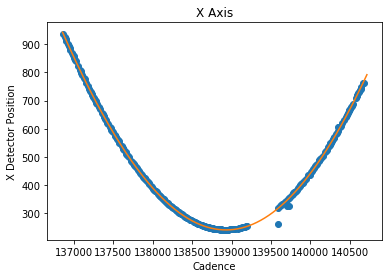

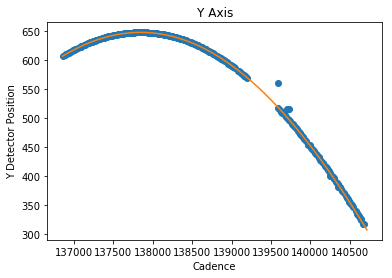

In [290]:
plt.scatter(cad[np.where(xs!=0)],xs[np.where(xs!=0)])
xlim=np.polyval(np.polyfit(cad[np.where(xs!=0)],xs[np.where(xs!=0)],4),cad)
plt.plot(cad,xlim,c='C1')
plt.xlabel('Cadence')
plt.ylabel('X Detector Position')
plt.title('X Axis')

plt.figure()

plt.scatter(cad[np.where(ys!=0)],ys[np.where(ys!=0)])
ylim=np.polyval(np.polyfit(cad[np.where(ys!=0)],ys[np.where(ys!=0)],4),cad)
plt.plot(cad,ylim,c='C1')
plt.xlabel('Cadence')
plt.ylabel('Y Detector Position')
plt.title('Y Axis')



/Users/ch/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':
/Users/ch/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in log10
/Users/ch/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in log10
/Users/ch/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in log10
/Users/ch/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in log10
/Users/ch/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in log10


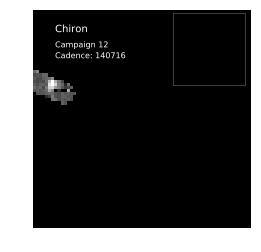

In [301]:
fig=plt.figure(figsize=(4,4))
tpf = fitsio.FITS(fnames[0])

n=35
n2=5
xoffset=0

ax=fig.add_subplot(111)
im=ax.imshow(np.log10(tpf[1].read()),cmap=cmap,vmin=0,vmax=3,origin='bottom',interpolation='none')
ax.set_xlim(xlim[0]-n,xlim[0]+n)
ax.set_ylim(ylim[0]-n,ylim[0]+n)
ax.axis('off')
text1=ax.text(0.1,0.9,'Chiron',fontsize=10,color='white',transform=ax.transAxes)
text1.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'),
                       path_effects.Normal()])
text2=ax.text(0.1,0.83,'Campaign 12',fontsize=8,color='white',transform=ax.transAxes)
text2.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'),
                       path_effects.Normal()])
text3=ax.text(0.1,0.78,'Cadence: {}'.format(int(cad[0])),fontsize=8,color='white',transform=ax.transAxes)
text3.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'),
                       path_effects.Normal()])


newax = fig.add_axes([0.62, 0.62 , 0.25, 0.25], zorder=2)
inset=newax.imshow(np.log10(tpf[1].read()),cmap=cmap,vmin=0,vmax=2.5,origin='bottom')
newax.set_xlim(xlim[0]-n2+xoffset,xlim[0]+n2+xoffset)
newax.set_ylim(ylim[0]-n2,ylim[0]+n2)
newax.spines['bottom'].set_color('red')
newax.spines['top'].set_color('red') 
newax.spines['right'].set_color('red')
newax.spines['left'].set_color('red')
newax.set_xticks([])
newax.set_yticks([])



def animate(i):
    tpf = fitsio.FITS(fnames[i])
    im.set_array(np.log10(tpf[1].read()))
    ax.set_xlim(xlim[i]-n+xoffset,xlim[i]+n+xoffset)
    ax.set_ylim(ylim[i]-n,ylim[i]+n)

    inset.set_array(np.log10(tpf[1].read()))
    newax.set_xlim(xlim[i]-n2+xoffset,xlim[i]+n2+xoffset)
    newax.set_ylim(ylim[i]-n2,ylim[i]+n2)

    text3.set_text('Cadence: {}'.format(int(cad[i])))
    return im,inset,text3,

anim = animation.FuncAnimation(fig,animate,frames=len(fnames), interval=15, blit=True)
anim.save('../chiron.mp4',dpi=150)

In [905]:
fnames=glob('../data/c6-ch39/*.fits')
tpf0=fits.open(fnames[0])
tpf0=tpf0[1].data

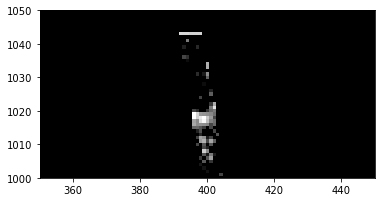

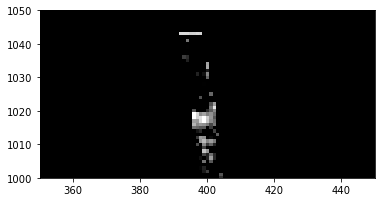

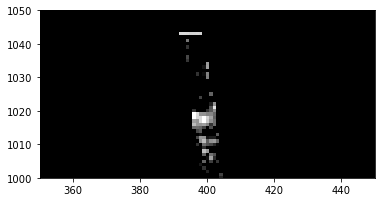

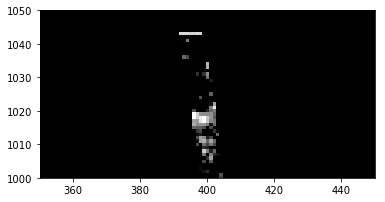

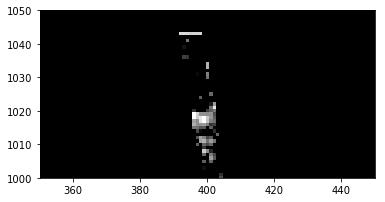

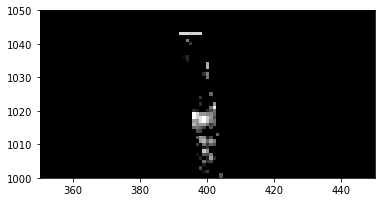

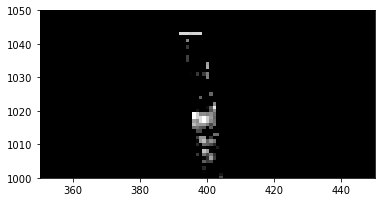

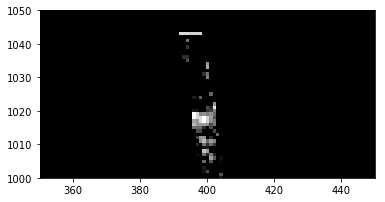

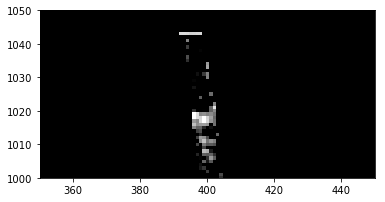

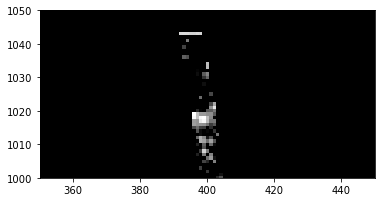

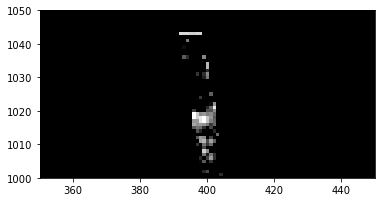

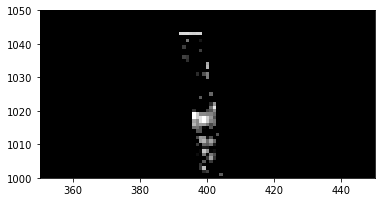

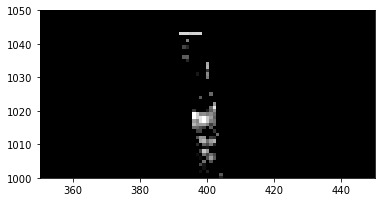

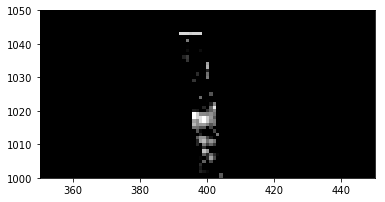

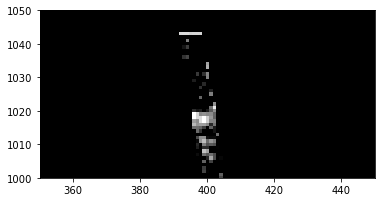

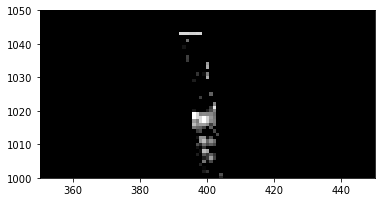

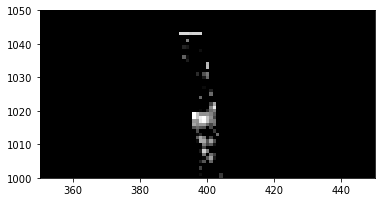

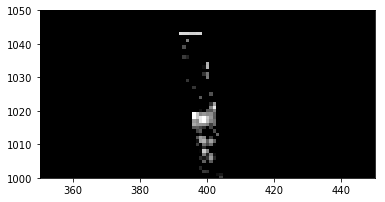

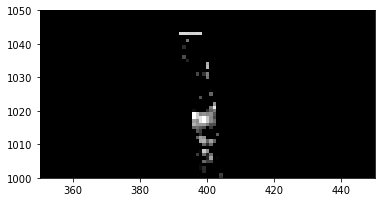

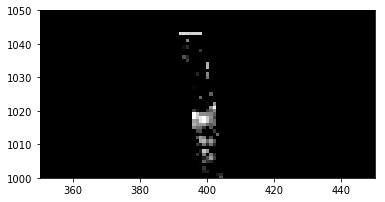

In [927]:
cmap = plt.get_cmap('gray')
cmap.set_bad('black',1.)
for f in range(0,20):
    h=fits.open(fnames[f*10])

    plt.figure()
    plt.imshow(np.log10(h[1].data),vmin=0,vmax=2,cmap=cmap)
    plt.ylim(1000,1050)
    plt.xlim(350,450)
